In [1]:
"""
    Load metadata
"""

import json

files = []
activities = []
persons = ["Ashima Gupta", "Achinth Venkat", "Oishe Farhan", "Liu Edward"]
with open('../raw/users.json') as jsonfile:
    metadata = json.load(jsonfile)
    for person in persons:
        #print(person)
        for session in metadata[person]['sessions']:
            activity = metadata[person]['sessions'][session]['activity']
            #print(activity, end=': ')
            #print(session)
            files.append(session)
            activities.append(activity)
        #print()
labels = []
for idx in range(len(activities)):
    if activities[idx] == 'Simon':
        labels.append(1)
    else:
        labels.append(0)
print(files)
print(labels)

['1552683620495_recording.csv', '1552684135826_recording.csv', '1552684518897_recording.csv', '1552684885683_recording.csv', '1552685274491_recording.csv', '1552686579599_recording.csv', '1552687068355_recording.csv', '1552687461872_recording.csv', '1552687730763_recording.csv', '1552688006554_recording.csv', '1552684886225_recording.csv', '1552685478381_recording.csv', '1552685952146_recording.csv', '1552686877018_recording.csv', '1552687454762_recording.csv', '1552687746756_recording.csv', '1552882289936_recording.csv', '1550862070278_recording.csv', '1551117337203_recording.csv', '1551117646871_recording.csv', '1551118061985_recording.csv', '1551118320943_recording.csv', '1551249571278_recording.csv', '1553039903059_recording.csv', '1553040206684_recording.csv', '1553040672641_recording.csv', '1553041018556_recording.csv', '1553041309127_recording.csv', '1553041571909_recording.csv', '1553041964221_recording.csv', '1553042270815_recording.csv', '1553042628553_recording.csv', '155268

In [2]:
from __future__ import print_function
import time
from functools import reduce
import math as m

import numpy as np
from numpy import genfromtxt
import pandas as pd
import matplotlib.pyplot as plt

import scipy.io
from scipy.interpolate import griddata
import scipy.stats as scs
from sklearn.preprocessing import scale

import re
import seaborn as sns

In [3]:
def gen_images(locs, features, n_gridpoints, normalize=True,
               augment=False, pca=False, std_mult=0.1, n_components=2, edgeless=False):
    """
    Generates EEG images given electrode locations in 2D space and multiple feature values for each electrode

    :param locs: An array with shape [n_electrodes, 2] containing X, Y
                        coordinates for each electrode.
    :param features: Feature matrix as [n_samples, n_features]
                                Features are as columns.
                                Features corresponding to each frequency band are concatenated.
                                (alpha1, alpha2, ..., beta1, beta2,...)
    :param n_gridpoints: Number of pixels in the output images
    :param normalize:   Flag for whether to normalize each band over all samples
    :param augment:     Flag for generating augmented images
    :param pca:         Flag for PCA based data augmentation
    :param std_mult     Multiplier for std of added noise
    :param n_components: Number of components in PCA to retain for augmentation
    :param edgeless:    If True generates edgeless images by adding artificial channels
                        at four corners of the image with value = 0 (default=False).
    :return:            Tensor of size [samples, colors, W, H] containing generated
                        images.
    """
    feat_array_temp = []
    nElectrodes = locs.shape[0]     # Number of electrodes
    # Test whether the feature vector length is divisible by number of electrodes
    assert features.shape[1] % nElectrodes == 0
    n_colors = features.shape[1] // nElectrodes
    for c in range(int(n_colors)):
        feat_array_temp.append(features[:, c * nElectrodes : nElectrodes * (c+1)])
    if augment:
        if pca:
            for c in range(n_colors):
                feat_array_temp[c] = augment_EEG(feat_array_temp[c], std_mult, pca=True, n_components=n_components)
        else:
            for c in range(n_colors):
                feat_array_temp[c] = augment_EEG(feat_array_temp[c], std_mult, pca=False, n_components=n_components)
    nSamples = features.shape[0]
    # Interpolate the values
    grid_x, grid_y = np.mgrid[
                     min(locs[:, 0]):max(locs[:, 0]):n_gridpoints*1j,
                     min(locs[:, 1]):max(locs[:, 1]):n_gridpoints*1j
                     ]
    temp_interp = []
    for c in range(n_colors):
        temp_interp.append(np.zeros([nSamples, n_gridpoints, n_gridpoints]))
    # Generate edgeless images
    if edgeless:
        min_x, min_y = np.min(locs, axis=0)
        max_x, max_y = np.max(locs, axis=0)
        locs = np.append(locs, np.array([[min_x, min_y], [min_x, max_y],[max_x, min_y],[max_x, max_y]]),axis=0)
        for c in range(n_colors):
            feat_array_temp[c] = np.append(feat_array_temp[c], np.zeros((nSamples, 4)), axis=1)
    # Interpolating
    for i in range(nSamples):
        for c in range(n_colors):
            temp_interp[c][i, :, :] = griddata(locs, feat_array_temp[c][i, :], (grid_x, grid_y),
                                    method='cubic', fill_value=np.nan)
        print('Interpolating {0}/{1}\r'.format(i+1, nSamples), end='\r')
    # Normalizing
    for c in range(n_colors):
        if normalize:
            temp_interp[c][~np.isnan(temp_interp[c])] = \
                scale(temp_interp[c][~np.isnan(temp_interp[c])])
        temp_interp[c] = np.nan_to_num(temp_interp[c])
    return np.swapaxes(np.asarray(temp_interp), 0, 1)     # swap axes to have [samples, colors, W, H]

def get_fft(snippet):
    Fs = 256.0;  # sampling rate
    snippet_time = len(snippet)/Fs
    Ts = 1.0/Fs; # sampling interval
    t = np.arange(0,snippet_time,Ts) # time vector

    y = snippet
    n = len(y) # length of the signal
    k = np.arange(n)
    T = n/Fs
    frq = k/T # two sides frequency range
    frq = frq[range(n//2)] # one side frequency range

    Y = np.fft.fft(y)/n # fft computing and normalization
    Y = Y[range(n//2)]
    return frq,abs(Y)

def theta_alpha_beta_averages(f,Y):
    theta_range = (4,8)
    alpha_range = (8,12)
    beta_range = (12,32)
    theta = Y[(f>=theta_range[0]) & (f<=theta_range[1])].mean()
    alpha = Y[(f>=alpha_range[0]) & (f<=alpha_range[1])].mean()
    beta = Y[(f>=beta_range[0]) & (f<=beta_range[1])].mean()
    return theta, alpha, beta

def make_steps(samples,frame_duration,overlap):
    '''
    in:
    samples - number of samples in the session
    frame_duration - frame duration in seconds 
    overlap - float fraction of frame to overlap in range (0,1)
    
    out: list of tuple ranges
    '''
    #steps = np.arange(0,len(df),frame_length)
    Fs = 256
    i = 0
    intervals = []
    samples_per_frame = Fs * frame_duration
    while i+samples_per_frame <= samples:
        intervals.append((i,i+samples_per_frame))
        i = i + samples_per_frame - int(samples_per_frame*overlap)
    return intervals

def make_frames(df,frame_duration):
    '''
    in: dataframe or array with all channels, frame duration in seconds
    out: array of theta, alpha, beta averages for each probe for each time step
        shape: (n-frames,m-probes,k-brainwave bands)
    '''
    Fs = 256.0
    frame_length = Fs*frame_duration
    frames = []
    steps = make_steps(len(df),frame_duration,overlap)
    for i,_ in enumerate(steps):
        frame = []
        if i == 0:
            continue
        else:
            for channel in df.columns:
                snippet = np.array(df.loc[steps[i][0]:steps[i][1],int(channel)])
                f,Y =  get_fft(snippet)
                theta, alpha, beta = theta_alpha_beta_averages(f,Y)
                frame.append([theta, alpha, beta])
            
        frames.append(frame)
    return np.array(frames)

def make_data_pipeline(path,file_names,labels,image_size,pulse_per_frame,frame_duration,overlap, locs_2d):
    '''
    IN: 
    file_names - list of strings for each input file (one for each subject)
    labels - list of labels for each
    image_size - int size of output images in form (x, x)
    frame_duration - time length of each frame (seconds)
    overlap - float fraction of frame to overlap in range (0,1)
    
    OUT:
    X: np array of frames (unshuffled)
    y: np array of label for each frame (1 or 0)
    '''
    ##################################
    ###Still need to do the overlap###!!!
    ##################################
    
    Fs = 256.0   #sampling rate
    frame_length = Fs * frame_duration
    
    print('Generating training data...')

    trim = 5
    
    for i, file in enumerate(file_names):
        print ('Processing session: ',file, '. (',i+1,' of ',len(file_names),')')
        
        df = pd.read_csv(path+file)
        df = df.loc[:, ['TP9', 'AF7', 'AF8', 'TP10']]
        df = df.truncate(before=trim*Fs, after=df.shape[0]-trim*Fs-1)
        buffer = df.values
        df = pd.DataFrame(buffer)
        
        X_0 = make_frames(df,frame_duration)
        #steps = np.arange(0,len(df),frame_length)
        X_1 = X_0.reshape(len(X_0),4*3) # 14 electrodes for test dataset
        
        images = gen_images(np.array(locs_2d), X_1, image_size, normalize=False)
        images = np.swapaxes(images, 1, 3)
        
        nImages = len(images)
        pulses = []
        start = 0
        for end in range(pulse_per_frame, nImages, pulse_per_frame):
            if (end+pulse_per_frame) >= nImages:
                pulses.append(images[nImages-pulse_per_frame:nImages,:])
            else:
                pulses.append(images[start:end,:])
            start = end
        pulses = np.array(pulses)
        
        print(nImages, ' frames generated with label ', labels[i], '.')
        print(len(pulses), ' frame pulses generated with label ', labels[i], '.')
        print('\n')
        if i == 0:
            X = pulses
            y = np.ones(len(pulses))*labels[0]
        else:
            X = np.concatenate((X,pulses),axis = 0)
            y = np.concatenate((y,np.ones(len(pulses))*labels[i]),axis = 0)
        
    return X,np.array(y)

In [4]:
filepath = '../raw/'

img_size = 24
locs_2d = [(-2.0,-1.0), # TP9
            (-2.0,2.0),  # AF7
            (2.0,2.0),   # AF8
            (2.0,-1.0)]  # TP10

pulse_per_frame = 10
frame_duration = 5.
overlap = 0.25

X, y = make_data_pipeline(filepath, files, labels, img_size, pulse_per_frame, frame_duration, overlap, locs_2d)
print(X.shape)
print(y.shape)

Generating training data...
Processing session:  1552683620495_recording.csv . ( 1  of  39 )
195  frames generated with label  1 .
19  frame pulses generated with label  1 .


Processing session:  1552684135826_recording.csv . ( 2  of  39 )
72  frames generated with label  0 .
7  frame pulses generated with label  0 .


Processing session:  1552684518897_recording.csv . ( 3  of  39 )
83  frames generated with label  0 .
8  frame pulses generated with label  0 .


Processing session:  1552684885683_recording.csv . ( 4  of  39 )
83  frames generated with label  0 .
8  frame pulses generated with label  0 .


Processing session:  1552685274491_recording.csv . ( 5  of  39 )
83  frames generated with label  1 .
8  frame pulses generated with label  1 .


Processing session:  1552686579599_recording.csv . ( 6  of  39 )
104  frames generated with label  1 .
10  frame pulses generated with label  1 .


Processing session:  1552687068355_recording.csv . ( 7  of  39 )
72  frames generated with l

0.0


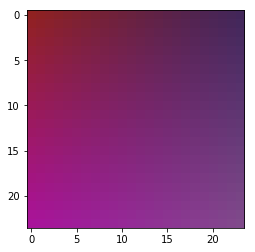

In [5]:
# the returned result should be a (sample, pulse_per_frame, img_size, img_size, rgb channels) np array
# i.e. (sample, time, img_size, img_size, rgb channels)

import matplotlib.pyplot as plt
%matplotlib inline

idx = 100
time = 5
print(y[idx])
plt.imshow(X[idx][time])
plt.show()

In [6]:
"""
    Save as npy
"""

np.save('EEGMapTimeseries_10F_5S.npy', X)
np.save('EEGMapTimeseries_10F_5S_Labels.npy', y)